In [2]:
import geopandas as gpd
from datetime import datetime
from metloom.pointdata import SnotelPointData
import xarray as xr
import pandas as pd

In [3]:
# pull in polygons of US states from the internet
states = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json')
# filter to only include Washington and Oregon
states_wa = states[states['NAME'].isin(['Washington'])]
states_or = states[states['NAME'].isin(['Oregon'])]
# explode states_wa and just save the largest one (to avoid problems with multipolygons from islands)
states_wa_mainland = states_wa.explode(index_parts=True).sort_values(by='geometry').iloc[-1:]
states_or_mainland = states_or.explode(index_parts=True).sort_values(by='geometry').iloc[-1:]


In [4]:
# define the variables we will want to grab
vrs = [SnotelPointData.ALLOWED_VARIABLES.SWE,
       SnotelPointData.ALLOWED_VARIABLES.PRECIPITATION,
       SnotelPointData.ALLOWED_VARIABLES.SNOWDEPTH]
# create a dataframe from all the points available in Washington
wa_points = SnotelPointData.points_from_geometry(states_wa_mainland, vrs)

In [5]:
# create a dataframe from all the points available in Washington
df_wa = wa_points.to_dataframe()
# filter to elevations between 3800 and 4200 feet
df_wa_filtered = df_wa[(df_wa['geometry'].z > 3800) & (df_wa['geometry'].z < 4200)]
# filter to only include stations west of the cascades
df_wa_filtered = df_wa_filtered[df_wa_filtered['geometry'].x < -120.5]
# save the filtered dataframe to a geojsonfile
df_wa_filtered.to_file('../data/01_raw/snotel_wa_4000ft.geojson', driver='GeoJSON')

In [6]:
# create a dataframe from all the points available in Oregon
or_points = SnotelPointData.points_from_geometry(states_or, vrs)

In [7]:
# create a dataframe from all the points available in Oregon
df_or = or_points.to_dataframe()
# filter to elevations between 3800 and 4200 feet
df_or_filtered = df_or[(df_or['geometry'].z > 3800) & (df_or['geometry'].z < 4200)]
# filter to only include stations west of the cascades
df_or_filtered = df_or_filtered[df_or_filtered['geometry'].x < -120.5]
# save the filtered dataframe to a geojsonfile
df_or_filtered.to_file('../data/01_raw/snotel_or_4000ft.geojson', driver='GeoJSON')

In [21]:
# create a function to grab the daily data from given variables and a given date range for a specific site with an id and name
# we want to return a dataframe
def get_daily_data(id, name, vrs, start_date, end_date):
    # create a pointdata object for the given site id and name
    point = SnotelPointData(id, name)
    # get the daily data for the given variables and date range
    df = point.get_daily_data(start_date, end_date, vrs)
    # grab the unique geometry from the df
    location = df['geometry'].unique()[0]
    # convert this geometry into a tuple
    location = (location.x, location.y, location.z)
    # remove the geometry from the dataframe
    df = df.drop('geometry', axis=1)
    # create an xarray dataset from the dataframe
    ds = df.to_xarray()
    # add the location values as lat, lon, elevation as a variable to the dataset dependent on the site
    ds['lat'] = location[1]
    ds['lon'] = location[0]
    ds['elevation'] = location[2]
    return ds

# create a function to go through indeces of the dataframe and grab the name and id to pass to the get_daily_data function
# then we want to add the returned dataframe and concatenate to an xarray dataset
# finally we want to return the dataset
def get_daily_data_ds(df, vrs, start_date, end_date):
    # create an empty list to append to
    ds_list = []
    # loop through the index of the dataframe
    for i in df.index:
        # grab the name and id from the dataframe
        name = df.loc[i]['name']
        id = df.loc[i]['id']
        # pass the name and id to the get_daily_data function and append to the list
        ds_list.append(get_daily_data(id, name, vrs, start_date, end_date))
    # concatenate the list of dataframes into one xarray dataset
    ds = xr.concat(ds_list, dim='site')
    for i,v in enumerate(vrs):
        ds[v.name] = ds[v.name].astype(float)
        # if the variable is SWE, Precipitation, Accumulated Precipitation, or Snow Depth then convert to centimeters from inches
        if v.name in ['SWE', 'PRECIPITATION', 'ACCUMULATEDPRECIPITATION', 'SNOWDEPTH']:
            ds[v.name] = ds[v.name] * 2.54
            # add an attribute to the variable of units = 'cm'
            ds[v.name].attrs['units'] = 'cm'
            # remove the variable_units variable
            ds = ds.drop(v.name + '_units')
    # get the first value of datasource
    datasource = ds['datasource'][0].values[0]
    # drop datasource variable
    ds = ds.drop('datasource')
    # add an attribute to the dataset of datasource
    ds.attrs['datasource'] = datasource
    
    # covert datetime
    ds['datetime'] = pd.to_datetime(ds['datetime']).date.astype('datetime64[ns]')
    # rename datetime to time
    ds = ds.rename({'datetime': 'time'})
    # return the dataset
    return ds

In [37]:
# define the start and end dates
start = datetime(2014, 10, 1)
end = datetime(2019, 4, 30)


# grab the results for Washington
result_wa = get_daily_data_ds(df_wa_filtered, vrs, start, end)
# filter out data where the diff between daily of SWE is greater than 50 cm
result_wa_filtered = result_wa.where((result_wa.diff('time').SWE < 50) & (result_wa.diff('time').SWE > -50), drop=True)
# save the results to a netcdf file
result_wa_filtered.to_netcdf('../data/01_raw/data_snotel_wa_4000ft.nc')
# grab the results for Oregon
result_or = get_daily_data_ds(df_or_filtered, vrs, start, end)
# save the results to a netcdf file
result_or.to_netcdf('../data/01_raw/data_snotel_or_4000ft.nc')

No SWE found for Government Camp
No PRECIPITATION found for Government Camp
Could not find timezone info for 353402:OR:COOP (Government Camp)


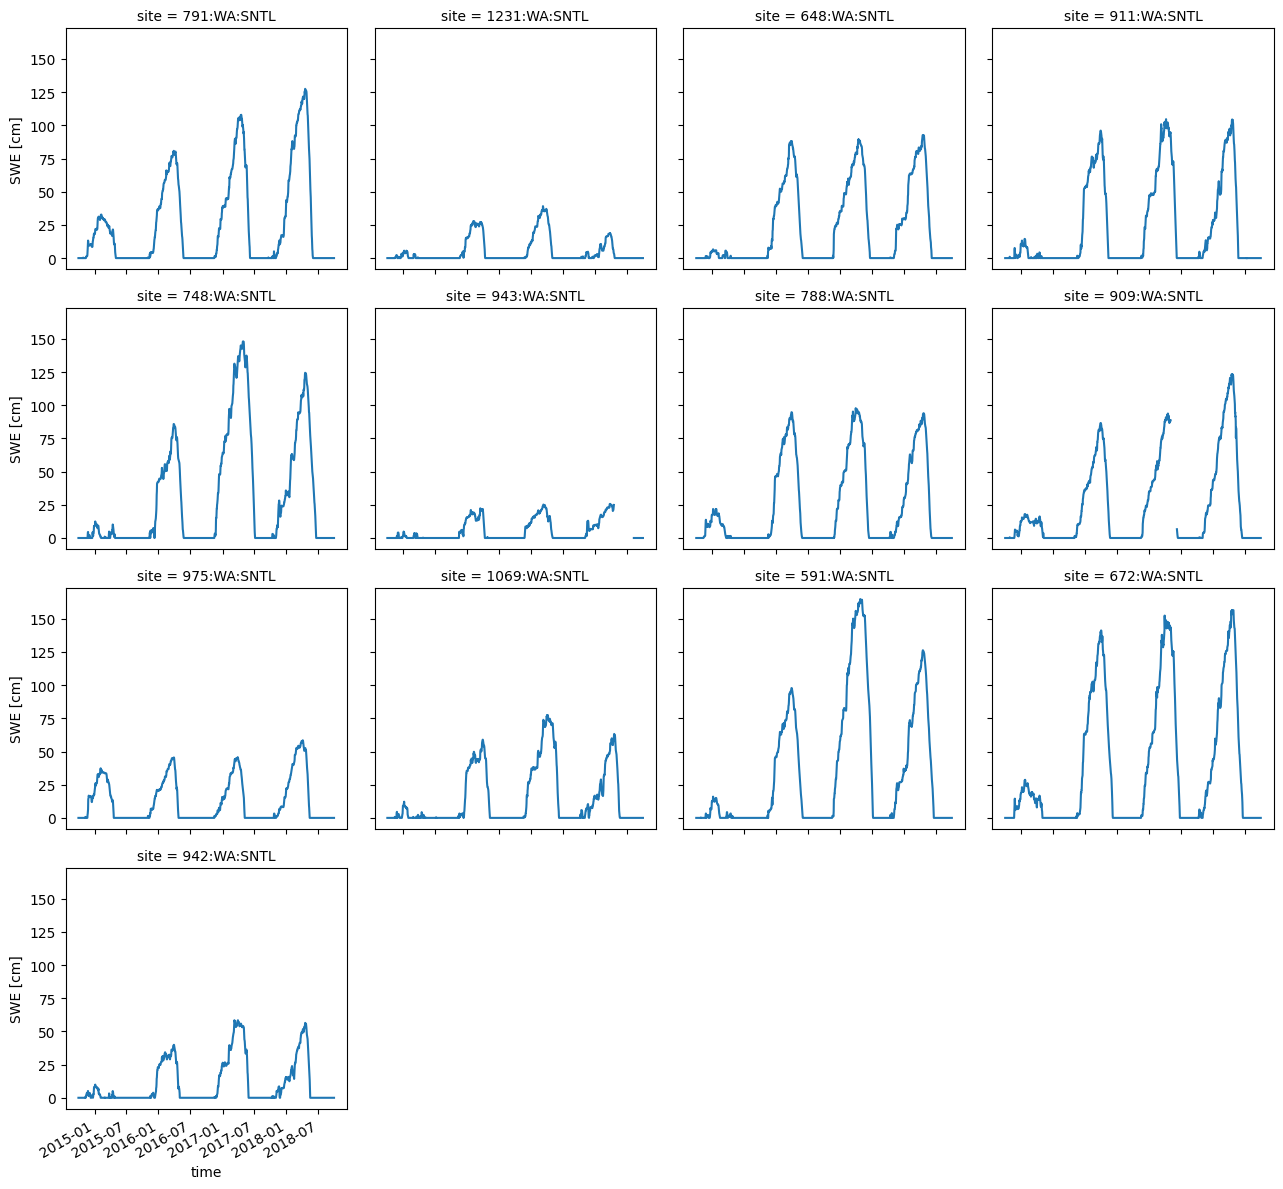

In [35]:
# plot the diff for swe for all sites
result_wa.SWE.plot.line(x='time', col='site', col_wrap=4)